In [116]:
!pip install torch==2.7.1 torchvision
!pip install opencv-python
!pip install onnx

In [117]:
import torchvision
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from time import time
import cv2
import onnx

In [118]:
print(torch.__version__)

2.7.1+cpu


In [119]:
print(torch.cuda.is_available())

False


In [120]:
current_path = os.getcwd()

In [121]:
path_of_dataset = os.path.join(current_path, "data")
print(path_of_dataset)

c:\dev\Source\LABS\Computer_Vision\Lesson_2\data


In [122]:
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

transform_augmented = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(
        degrees=10,
        translate = (0.1, 0.1),
        scale = (0.9, 1.1),
        shear = 10
    ),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ElasticTransform(alpha=10.0, sigma=5.0),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

In [123]:
original_dataset = torchvision.datasets.MNIST(path_of_dataset, download=True, train=True, transform=transform_original)
augmented_dataset = torchvision.datasets.MNIST(path_of_dataset, download=True, train=True, transform=transform_augmented)

train_set = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset])
# train_set = torch.utils.data.ConcatDataset([original_dataset])

In [124]:
test_set = torchvision.datasets.MNIST(path_of_dataset, download = True, train = False, transform = transform_original)

In [125]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = True)

In [126]:
print(train_loader)

Text(0.5, 1.0, 'Label: 4')

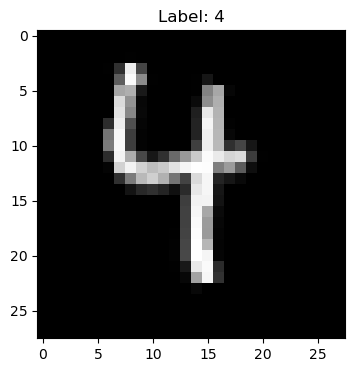

In [127]:
data_iter = iter(train_loader)

images, labels = next(data_iter) # get current batch (size = 64) -> get current 64 images. C H W
current_img= images[0].numpy().squeeze(0)
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.imshow(current_img, cmap='gray')
axes.set_title(f"Label: {labels[0]}")

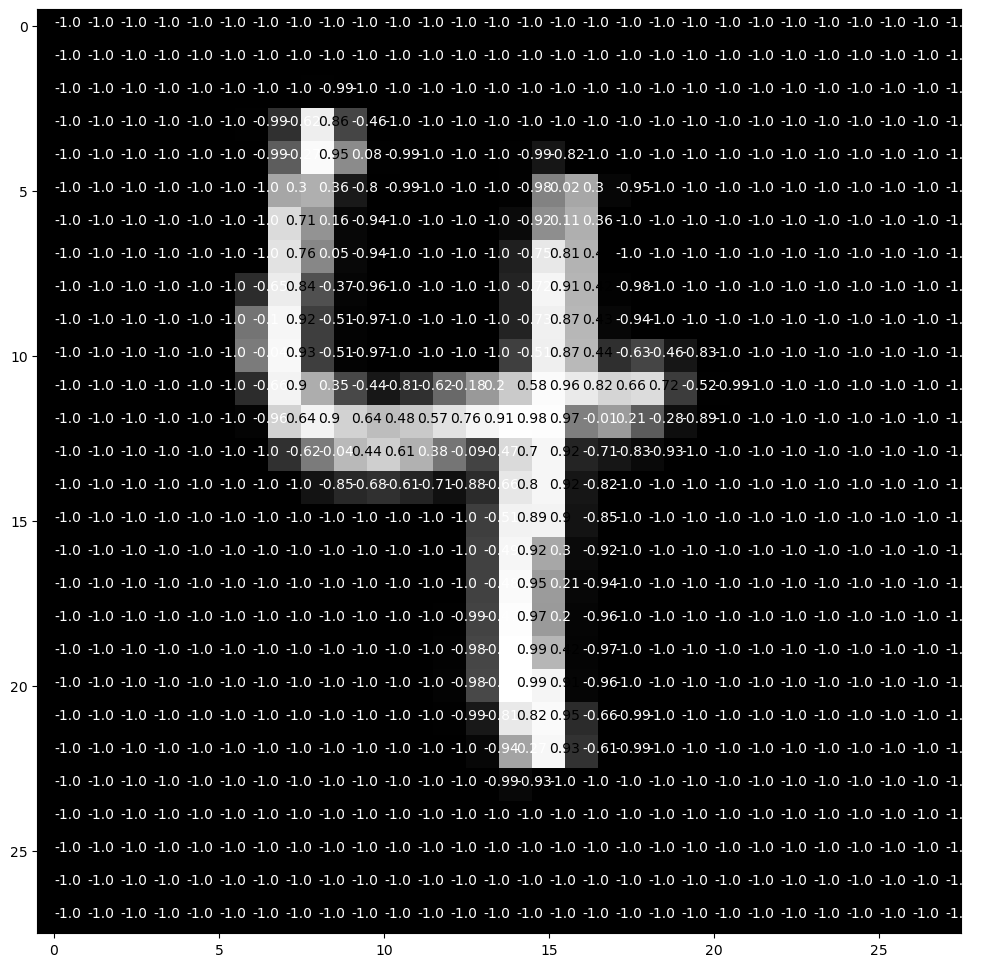

In [128]:
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(current_img, cmap='gray')
width, height = current_img.shape
thresh = current_img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(current_img[x][y],2) if current_img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
            color='white' if current_img[x][y]<thresh else 'black')

In [129]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convolution_1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.convolution_2 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.fc_1 = torch.nn.Linear(8*7*7, 128)
        self.fc_2 = torch.nn.Linear(128, 64)
        self.fc_3 = torch.nn.Linear(64, 10)
        self.dropout = torch.nn.Dropout(p=0.25)

    def forward(self, x):
        #x = torch.nn.functional.relu(self.convolution_1(x))
        x = (self.convolution_1(x))
        x = self.pooling(x)
        #x2 = torch.nn.functional.relu(self.convolution_2(x))
        x2 =(self.convolution_2(x))
        x = x + x2
        x = self.pooling(x)
        x = x.view(-1, 8 * 7 * 7)
        #x = torch.nn.functional.relu(self.fc_1(x))
        x = (self.fc_1(x))
        x = self.dropout(x)
        # x = torch.nn.functional.relu(self.fc_2(x))
        x =(self.fc_2(x))
        x = self.fc_3(x)
        return x


In [130]:
net = Net()

In [131]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 10

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        res = net(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)


correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 2.169
[1,   200] loss: 1.103
[1,   300] loss: 0.709
[1,   400] loss: 0.583
[1,   500] loss: 0.478
[1,   600] loss: 0.403
[1,   700] loss: 0.392
[1,   800] loss: 0.340
[1,   900] loss: 0.313
[1,  1000] loss: 0.291
[1,  1100] loss: 0.282
[1,  1200] loss: 0.280
[1,  1300] loss: 0.271
[1,  1400] loss: 0.262
[1,  1500] loss: 0.260
[1,  1600] loss: 0.253
[1,  1700] loss: 0.258
[1,  1800] loss: 0.236
[2,   100] loss: 0.218
[2,   200] loss: 0.225
[2,   300] loss: 0.224
[2,   400] loss: 0.226
[2,   500] loss: 0.221
[2,   600] loss: 0.220
[2,   700] loss: 0.219
[2,   800] loss: 0.212
[2,   900] loss: 0.196
[2,  1000] loss: 0.210
[2,  1100] loss: 0.189
[2,  1200] loss: 0.209
[2,  1300] loss: 0.184
[2,  1400] loss: 0.190
[2,  1500] loss: 0.196
[2,  1600] loss: 0.196
[2,  1700] loss: 0.179
[2,  1800] loss: 0.182
[3,   100] loss: 0.178
[3,   200] loss: 0.185
[3,   300] loss: 0.179
[3,   400] loss: 0.178
[3,   500] loss: 0.169
[3,   600] loss: 0.178
[3,   700] loss: 0.180
[3,   800] 

In [146]:
class NetDepthwise(torch.nn.Module):
    def __init__(self):
        super(NetDepthwise, self).__init__()

        self.depthwise1 = torch.nn.Conv2d(1, 1, kernel_size=3, padding=1, groups=1)
        self.pointwise1 = torch.nn.Conv2d(1, 8, kernel_size=1)
        
        self.pooling = torch.nn.MaxPool2d(2, 2)
        
        self.depthwise2 = torch.nn.Conv2d(8, 8, kernel_size=3, padding=1, groups=8)
        self.pointwise2 = torch.nn.Conv2d(8, 8, kernel_size=1)
        
        self.fc_1 = torch.nn.Linear(8*7*7, 128)
        self.fc_2 = torch.nn.Linear(128, 64)
        self.fc_3 = torch.nn.Linear(64, 10)
        self.dropout = torch.nn.Dropout(p=0.25)

        self.relu = torch.nn.ReLU()

    def forward(self, x):

        x = self.depthwise1(x)
        x = self.pointwise1(x)
        x = self.relu(x)

        x = self.pooling(x)

        x2 = self.depthwise2(x)
        x2 = self.pointwise2(x2)
        x2 = self.relu(x)

        x = x + x2 

        x = self.pooling(x)

        x = x.view(-1, 8 * 7 * 7)
        x = self.relu(self.fc_1(x))

        x = self.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [147]:
net_depthwise = NetDepthwise()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_depthwise.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        res = net_depthwise(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)


correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_depthwise(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

In [135]:
x = torch.randn(64, 1, 28,28)
torch.onnx.export(net_depthwise, x, os.path.join(path_of_dataset, "conv.onnx"))

In [142]:
x = torch.randn(64, 1, 28,28)
torch.onnx.export(net, x, os.path.join(path_of_dataset, "conv_net.onnx"))

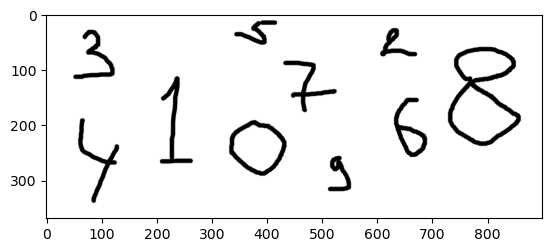

In [136]:
image = cv2.imread("data/0-9.png") # загружаем картинку в ЧБ

plt.imshow(image, cmap='gray')

In [137]:
model=cv2.dnn.readNetFromONNX(os.path.join(path_of_dataset, "conv.onnx"))

In [138]:
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img.shape[:2]

In [139]:
img_for_detect = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0 
img_for_detect = (img_for_detect - 0.5) / 0.5

In [140]:
for c in contours:

    x, y, w, h = cv2.boundingRect(c)
    
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255,255,0),1)
    
    sz2 = int(1.1*max(w,h)/2)
    
    xc = x + int(w/2)
    yc = y + int(h/2)
    
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255,0,0),1)
    
    img2 = img[max(0,yc-sz2):min(yc+sz2,height-1),max(0,xc-sz2):min(width-1,xc+sz2)]
    img2 = cv2.resize(img2, (28, 28))
    
    blob = cv2.dnn.blobFromImage(img2, 1./127, (28,28), (127,127,127), True)
    
    model.setInput(blob)
    outs = model.forward()
    res = np.argmax(outs)

    cv2.putText(image, str(res), (x, y+h),  cv2.FONT_HERSHEY_SIMPLEX,
	1.5, (50, 50, 255),1)

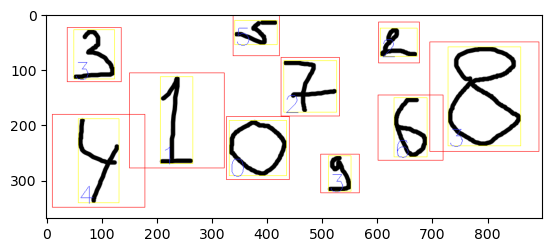

In [141]:
plt.imshow(image, cmap="gray")